# Problem

February 9, 2025

## Suppose that we have the following portfolio of positions as of 30/10/2023:

### (a) a payer (i.e. pay fixed leg and receive float leg) SOFR swap with the following contract parameters:

- Notional: $100 million
- Starting Date: 30/10/2023
- Maturity: 10Y
- Strike: 4.2%
- FloatLeg Frequency: Annual 
- FixedLeg Frequency: Annual

### (b) $1 million in each of the four stocks: AAPL, MSFT, F (Ford Motor) and BAC (Bank of America)

An Excel workbook consisting of one-year of historical data (31/10/2022 - 30/10/2023) of the SOFR curve and the share prices of the four stocks above, and an Excel workbook demonstrating the pricing of a SOFR swap have been provided. Using the data, calculate the 1-day 95% VaR for the portfolio as of 30/10/2023 using each of the following models:

    (a) Parametric VaR Model
    (b) Monte Carlo VaR Model (under both the full revaluation and the sensitivity-based ap- proaches). You may assume the risk factor changes are Normally distributed.
    (c) Historical VaR Model (under both the the full revaluation and the sensitivity-based ap- proaches)

## Libraries

In [1]:
import numpy as np
import numpy.typing as npt
import datetime
import os
import math
import pandas as pd
import scipy.stats as stat
import scipy.interpolate
from scipy.stats import qmc, norm
import matplotlib.pyplot as plt

from typing import Literal

import warnings

In [2]:
def plot_distribution(data, threshold, plot_title):
    """
    Plots a histogram with a fitted normal distribution curve and a vertical reference line.

    Args:
        data (array-like): The dataset to be visualized.
        threshold (float): The value where a vertical reference line is drawn.
        plot_title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(plot_title)

    # Plot histogram with density normalization
    ax.hist(data, bins=50, density=True, alpha=0.5)

    # Add vertical line at negative threshold
    ax.axvline(-threshold, color='r')    # var cutoff

    # Fit normal distribution to data
    mean, std_dev = norm.fit(data)
    x_vals = np.linspace(data.min(), data.max(), 10000)
    pdf_vals = norm.pdf(x_vals, mean, std_dev)

    # Overlay normal distribution curve
    ax.plot(x_vals, pdf_vals, 'k', linewidth=2)

    # Format x-axis labels as currency
    ax.xaxis.set_major_formatter('${x:1,.0f}')

## DATA PRE-PROCESSING

In [3]:
# sofr = pd.read_excel("hist_data.xlsm", sheet_name = "SofrCurve")
AAPL = pd.read_excel("hist_data.xlsm", sheet_name = "AAPL").set_index('Date')
MSFT = pd.read_excel("hist_data.xlsm", sheet_name = "MSFT").set_index('Date')
F = pd.read_excel("hist_data.xlsm", sheet_name = "F").set_index('Date')
BAC = pd.read_excel("hist_data.xlsm", sheet_name = "BAC").set_index('Date')

In [4]:
file_directory = "./hist_data.xlsm"
sofr = pd.read_excel(file_directory, sheet_name="SofrCurve")  # [:16]  # just take the necessary tenors ~ 1Y-10Y

# PARAMETERS:

In [5]:
VaR_percentile = 5 # 95% confidence level
swap_notional = 100e6
stocks_notional = np.array([1e6] * 4)  # stocks holding value

# STOCKS

In [6]:
AAPL=AAPL.rename(columns={'Adj Close':'AAPL Adj Close'})
MSFT=MSFT.rename(columns={'Adj Close':'MSFT Adj Close'})
F=F.rename(columns={'Adj Close':'F Adj Close'})
BAC=BAC.rename(columns={'Adj Close':'BAC Adj Close'})

## 1. Stocks Prices:

In [7]:
stocks = pd.concat([AAPL, MSFT, F, BAC], axis=1)

stocks.head()

,AAPL Adj Close,MSFT Adj Close,F Adj Close,BAC Adj Close
Date,,,,
2022-10-31,152.041122,229.443207,11.974380,34.748581
2022-11-01,149.373917,225.529037,12.001248,34.902847
2022-11-02,143.801514,217.552444,11.696740,34.796783
2022-11-03,137.703613,211.770157,11.875863,34.603954
2022-11-04,137.435455,218.827515,12.099767,35.471703


In [8]:
# How many shares we owned

stock_latest_price = stocks.iloc[-1].to_numpy()
share_holdings = stocks_notional / stock_latest_price # shares owned, our stocks weight

In [9]:
share_holdings

array([  5887.57567102,   2970.64906632, 103950.1039501 ,  39236.33227869])

## 2. Stocks Risk Factor $ \Delta x_{0,1d}^{(k)} $: daily relative return of the stock prices

In [10]:
stocks_daily_return = stocks.pct_change().rename(columns={'AAPL Adj Close':'AAPL daily return',
                         'MSFT Adj Close':'MSFT daily return',
                         'F Adj Close':'F daily return',
                         'BAC Adj Close':'BAC daily return'}).dropna()
stocks_daily_return.head()

,AAPL daily return,MSFT daily return,F daily return,BAC daily return
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980


In [11]:
# stocks_daily_return[stocks_daily_return.isna().any(axis=1)] # check for missing values

# SWAP

## 1. SOFR Prices - SOFR Zero rates

In [12]:
sofr=sofr.set_index("Tenor").transpose().drop("T") #set tenor as index for later merging
sofr.index = pd.to_datetime(sofr.index)
sofr.head()

Tenor,1D,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,15Y,16Y,17Y,18Y,19Y,20Y,25Y,30Y,35Y,40Y
2022-10-31,0.039191,0.038721,0.038670,0.040536,0.044577,0.046004,0.046449,0.044583,0.042002,0.040318,...,0.037151,0.037057,0.036907,0.036698,0.036433,0.036111,0.034091,0.032350,0.030552,0.028708
2022-11-01,0.039604,0.039023,0.038886,0.040725,0.044849,0.046448,0.046970,0.045022,0.042344,0.040614,...,0.036802,0.036682,0.036511,0.036287,0.036010,0.035678,0.033645,0.031979,0.030238,0.028478
2022-11-02,0.039948,0.039286,0.039100,0.040852,0.044884,0.046580,0.047203,0.045496,0.042749,0.040868,...,0.036855,0.036701,0.036498,0.036248,0.035953,0.035613,0.033627,0.031936,0.030292,0.028608
2022-11-03,0.040389,0.039585,0.039350,0.041154,0.045281,0.047107,0.047894,0.046594,0.043833,0.041825,...,0.037221,0.037069,0.036886,0.036657,0.036372,0.036022,0.033811,0.032134,0.030407,0.028655
2022-11-04,0.045965,0.042343,0.038795,0.040611,0.045212,0.046752,0.047500,0.046097,0.043385,0.041503,...,0.037687,0.037557,0.037380,0.037152,0.036870,0.036534,0.034424,0.032558,0.030723,0.028933


## 2. Find SOFR Swap Present Value to get the initial portfolio value :
(Swap's Maturity=10Y, so only filter 1Y~10Y zero rates to discount, the result will be the same if calculating it using Prof's 'Swap Pricing Example Excel'):
$$
DF(T) = e^{-r(T) \times T}
$$

$$
PV_{\text{fixed}} = \sum_{T=1}^{10} \left( CF_{\text{fixed},T} \times DF(T) \right)
$$

$$
PV_{\text{float}} = \sum_{T=1}^{10} \left( CF_{\text{float},T} \times DF(T) \right)
$$

$$
PV_{\text{swap}} = PV_{\text{float}} - PV_{\text{fixed}}
$$


In [13]:
def compute_discount_factors(DF: pd.DataFrame) -> pd.DataFrame:
    """
    Compute discount factors for each column in the given DataFrame.

    Args:
        DF (pd.DataFrame): DataFrame where each column contains continuous rates.

    Returns:
        pd.DataFrame: DataFrame with discount factors applied.
    """
    DF = DF.copy()  # Avoid modifying the original DataFrame
    for i, col in enumerate(DF.columns):
        DF[col] = np.exp(-DF[col].astype(float) * (i + 1))
    return DF

In [14]:
def PV_payer_swap(discount_factors: np.ndarray,  fixed_leg_rate: float = 0.042) -> float:
    """
    Computes the present value (PV) of a payer swap.

    Args:
        discount_factors (np.ndarray): Array of discount factors.

    Returns:
        float: PV of the payer swap.
    """
    float_leg = 1 - discount_factors[-1]  # Use the last discount factor dynamically
    fix_leg = fixed_leg_rate * np.sum(discount_factors)

    PV = swap_notional * (float_leg - fix_leg)
    
    return PV

In [15]:
matching_tenors = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']

sofr_10 = sofr[matching_tenors].copy()
sofr_10_disc = compute_discount_factors(sofr_10)
base_rates = sofr_10_disc.iloc[-1,].to_numpy() # sofr rates on latest date '2023-10-30'
base_pv = PV_payer_swap(base_rates)

print(f"Swap Present Value PV: ${base_pv:,.4f}")

Swap Present Value PV: $2,442,901.9998


## 3. SOFR risk factor $ \Delta x_{0,1d}^{(k)} $: absolute daily changes in the zero rate risk factors (all the 30 zero rates) 
##### Hint: This is because the value of the swap depends only on discount factors of the SOFR curve which are all determined by the 30 zero rates.

In [16]:
sofr_dailychange = sofr.diff().dropna() 
sofr_dailychange[matching_tenors].head()   # sofr delta

Tenor,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
2022-11-01,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-0.000097,-0.000144
2022-11-02,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,0.000090,0.000091
2022-11-03,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,0.000545,0.000495
2022-11-04,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,0.000126,0.000192
2022-11-07,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,0.000345,0.000339


In [17]:
sofr_delta = sofr_dailychange[matching_tenors]

In [57]:
# sofr_dailychange[sofr_dailychange.isna().any(axis=1)]

## 4. SOFR Swap $PVO1$:
$$
PV01 = \frac{P_{\text{SOFR Swap, r+1bp}} - P_{\text{SOFR Swap, r}}}{0.0001}
$$

In [19]:
def calculate_pv01(sofr: pd.DataFrame, bips: float = 0.0001) -> np.ndarray:
    """
    Computes the PV01 for a payer swap by shifting each tenor rate up by 1 basis point.

    Args:
        sofr (pd.DataFrame): SOFR rates with tenors as columns.
        bp_change (float, optional): Basis point change to apply. Default is 0.0001 (1 bp).

    Returns:
        np.ndarray: Array of PV01 values for each tenor.
    """
    n_tenors = sofr.shape[1]  # Number of tenors (1Y-10Y)
    payer_change = np.zeros(n_tenors)

    # Get the latest SOFR rates
    sofr_today = sofr.iloc[-1].to_numpy()

    # Compute discount factors for the unshifted rates
    discount_factors_today = compute_discount_factors(pd.DataFrame(sofr_today).T).to_numpy().flatten()
    payer_swap_today = PV_payer_swap(discount_factors_today)

    for tenor in range(n_tenors):
        # Copy rates and apply a 1bp shift to the current tenor
        sofr_shifted = sofr_today.copy()
        sofr_shifted[tenor] += bips

        # Compute new discount factors
        discount_factors_shifted = compute_discount_factors(pd.DataFrame(sofr_shifted).T).to_numpy().flatten()

        # Compute change in PV due to the shift
        payer_change[tenor] = PV_payer_swap(discount_factors_shifted) - payer_swap_today

    # Convert from basis points to percentage rates
    return payer_change / bips


In [20]:
pv01 = calculate_pv01(sofr[matching_tenors])
# pv01

# Initial Portfolio Total Value $ P_0 $:
 total initial value of the portfolio (for calculating P&L):
   $$ P_0 = P_{\text{SOFR Swap}} + 1M(AAPL) + 1M(MSFT) + 1M(F) + 1M(BAC) $$

In [21]:
P0 = base_pv + stocks_notional.sum()   #total portfolio

print(f"Stock PV: ${round(stocks_notional.sum(), 2):,}")
print(f"Swap PV: ${round(base_pv, 2):,}")
print(f"Portfolio Value: ${round(P0, 2):,}")

Stock PV: $4,000,000.0
Swap PV: $2,442,902.0
Portfolio Value: $6,442,902.0


# Initiating Global Variables

In [22]:
latest_stock_price = stocks.iloc[-1,].to_numpy()  # stock price on 2023-10-30
latest_sofr_rate = sofr_10.iloc[-1,].to_numpy()  # sofr rate on 2023-10-30
sofr_delta = sofr_dailychange[matching_tenors]   # sofr risk factor

# (a) PARAMETRIC VAR

In [46]:
# STOCKS
stocks_mean = stocks_daily_return.mean(axis = 0)
stocks_std = stocks_daily_return.std(axis = 0)
stocks_cov = stocks_daily_return.cov().to_numpy()

# calculate new prices for parametric VaR
Para_stock_mean = (stocks_mean * stocks_notional).sum()
Para_stock_std = np.sqrt(np.matmul(np.matmul(stocks_notional, stocks_cov), stocks_notional.T))

In [24]:
# SWAP
sofr_mean = sofr_delta.mean(axis = 0).to_numpy()
sofr_std = sofr_delta.std(axis = 0).to_numpy()
sofr_cov = (sofr_delta).cov(numeric_only = False).to_numpy()

# calculate new swap prices 
Para_swap_mean = (pv01 * sofr_mean).sum()
Para_swap_std = np.sqrt(np.matmul(np.matmul(pv01, sofr_cov), pv01.T))

In [25]:
z = norm.ppf(VaR_percentile / 100)

Para_stock_VaR = abs(Para_stock_mean + z * Para_stock_std)
Para_swap_VaR = abs(Para_swap_mean + z * Para_swap_std)

print(f'Parametric Stock 95% VaR: ${round(Para_stock_VaR, 2):,}')
print(f'Parametric Swap 95% VaR: ${round(Para_swap_VaR, 2):,}')

Parametric Stock 95% VaR: $87,730.5
Parametric Swap 95% VaR: $932,895.24


# Parametric VaR Portfolio ($P_0$):

In [26]:
# PORTFOLIO

Para_port_mean = Para_swap_mean + Para_stock_mean
Para_port_std = np.sqrt(Para_stock_std ** 2 + Para_swap_std ** 2)

Para_port_VaR = abs(Para_port_mean + z * Para_port_std)

print(f'Parametric 95% VaR Portfolio: ${round(Para_port_VaR, 2):,}')

Parametric 95% VaR Portfolio: $936,434.42


In [52]:
print(f"{Para_port_std**2:,.2f}")

339,143,826,059.27


# (b) MONTE CARLO VAR

In [28]:
# use the numpy function to generate instead of the manual cholesky method
def simulate_correlated(dimension, power, corr_matrix, mean, std):
    """Generates correlated normal samples using NumPy's multivariate normal."""
    # Step 1: Generate Sobol samples
    simulation = qmc.Sobol(d=dimension, scramble=False).random_base2(m=power)[1:]  # Skip first row

    # Step 2: Convert to normal distribution
    normal_samples = norm.ppf(simulation)

    # Step 3: Generate correlated samples using NumPy's multivariate normal
    cov_matrix = np.outer(std, std) * corr_matrix  # Convert correlation to covariance
    correlated_samples = np.random.multivariate_normal(mean, cov_matrix, size=normal_samples.shape[0])

    return correlated_samples

In [29]:
# simulate stocks returns
stock_simulated_returns = simulate_correlated(
    dimension=4, power=20, # 2^20
    corr_matrix=stocks_daily_return.corr().to_numpy(), 
    mean=stocks_mean, std=stocks_std
)

# simulate SOFR rate changes
sofr_simulated = simulate_correlated(
    dimension=len(sofr_delta.columns), power=20, 
    corr_matrix=sofr_delta.corr(numeric_only=False).to_numpy(), 
    mean=sofr_mean, std=sofr_std
)

In [30]:
# USING CHOLESKY - NOT A GOOD IDEA, doesn't account for cov between stocks and sofr rates, result semi positive definite
# def simulate_correlated(dimension, power, corr_matrix, mean, std):
#     """Generates correlated normal samples using Sobol sequences."""
#     # Step 1: Generate Sobol samples
#     simulation = qmc.Sobol(d=dimension, scramble=False).random_base2(m=power)[1:]  # Skip first row

#     # Step 2: Convert to normal distribution
#     normal_samples = norm.ppf(simulation, loc=mean, scale=std)

#     # Step 3: Apply Cholesky decomposition for correlation
#     cholesky_matrix = np.linalg.cholesky(corr_matrix)
#     correlated_samples = normal_samples @ cholesky_matrix.T  # More efficient than np.matmul

#     return correlated_samples

## 1. Full Revaluation Approach

### STOCKS

Monte Carlo Full Revaluation Stock 95% VaR: $87,914.55


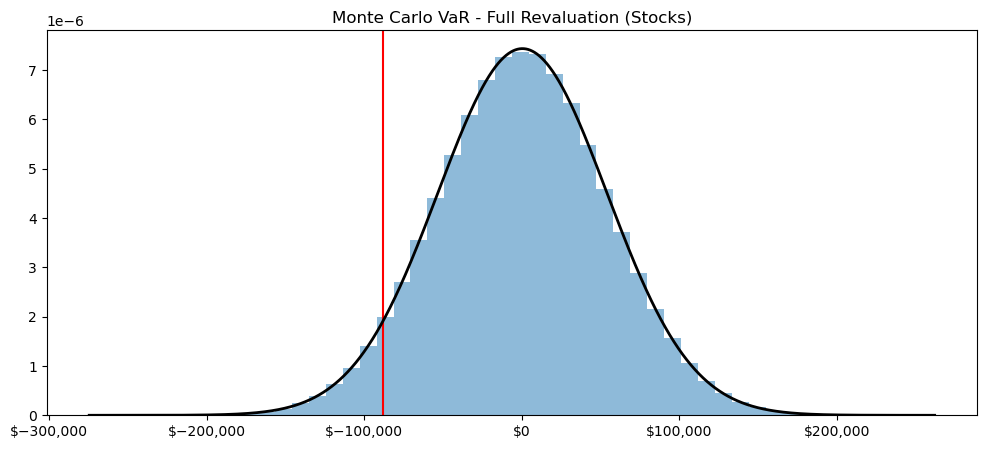

In [31]:
# apply latest stock price to the risk factor (stocks_daily_return) and get new stock prices
MC_FR_prices = latest_stock_price * (1 + stock_simulated_returns) 

# multiply our shares and the new prices to get new portfolio
MC_FR_stocks_portfolio = share_holdings * MC_FR_prices   
MC_FR_stocks_portfolio_changes = (MC_FR_stocks_portfolio - stocks_notional).sum(axis = 1) 

hist_MC_stocks_VaR = abs(np.percentile(MC_FR_stocks_portfolio_changes, VaR_percentile))

print(f'Monte Carlo Full Revaluation Stock 95% VaR: ${round(hist_MC_stocks_VaR, 2):,}')
plot_distribution(MC_FR_stocks_portfolio_changes, hist_MC_stocks_VaR, 'Monte Carlo VaR - Full Revaluation (Stocks)')

### SWAP

Monte Carlo Full Revaluation Swap 95% VaR: $937,301.03


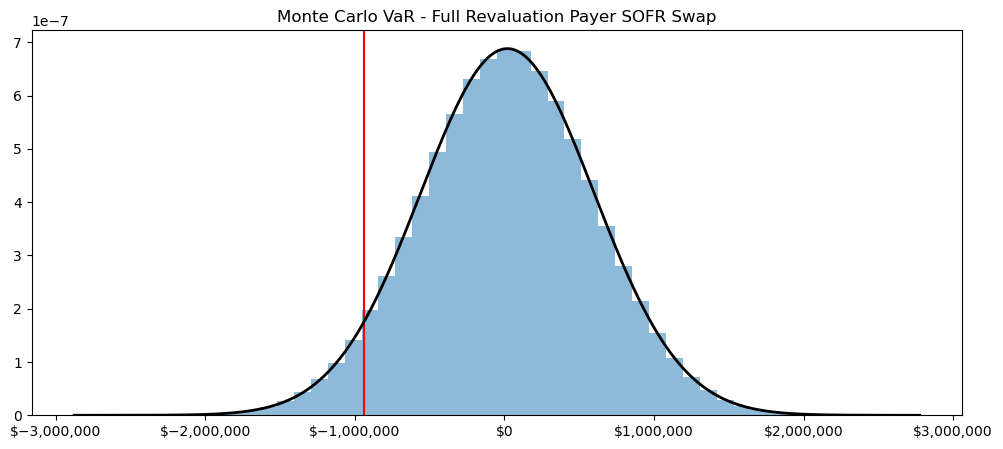

In [32]:
# apply historical rate changes to today's rates
new_MC_sofr_10 = pd.DataFrame(latest_sofr_rate + sofr_simulated)
new_MC_sofr_10_disc = compute_discount_factors(new_MC_sofr_10).to_numpy()  # DF is now discount factors for each maturities

n = len(sofr_simulated)
MC_FR_payer = np.zeros(n)

# compute payer swap value for each risk factor
for i in range(n):
    MC_FR_payer[i] = PV_payer_swap(new_MC_sofr_10_disc[i]) 

# calculate change in value of swap
MC_FR_payer = MC_FR_payer - base_pv    # base_pv: swap initial portfolio
MC_FR_payer_VaR = abs(np.percentile(MC_FR_payer, VaR_percentile))

print(f'Monte Carlo Full Revaluation Swap 95% VaR: ${round(MC_FR_payer_VaR, 2):,}')
plot_distribution(MC_FR_payer, MC_FR_payer_VaR, 'Monte Carlo VaR - Full Revaluation Payer SOFR Swap')


## Monte Carlo VaR - Full Revaluation Approach Portfolio ($ P_0 $):

Monte Carlo Full Revaluation Portfolio 95% VaR: $941,279.90


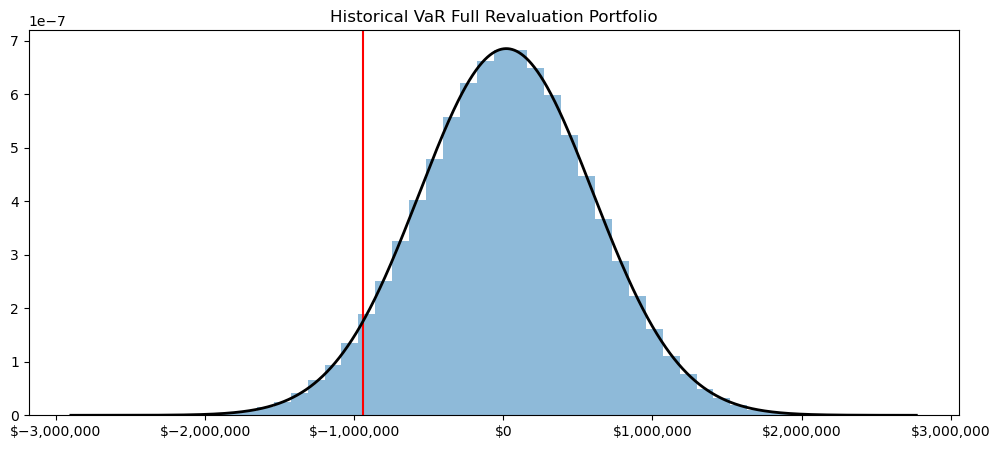

In [33]:
# combine together stock and swap
MC_FR_portfolio_changes = MC_FR_stocks_portfolio_changes + MC_FR_payer

MC_FR_VaR = abs(np.percentile(MC_FR_portfolio_changes, VaR_percentile))

print(f"Monte Carlo Full Revaluation Portfolio 95% VaR: ${MC_FR_VaR:,.2f}")
plot_distribution(MC_FR_portfolio_changes, MC_FR_VaR, 'Historical VaR Full Revaluation Portfolio')


## 2. Sensitivity-Based Approach

### STOCKS

Monte Carlo Sensitivity-Based Stocks 95% VaR: $87,914.55


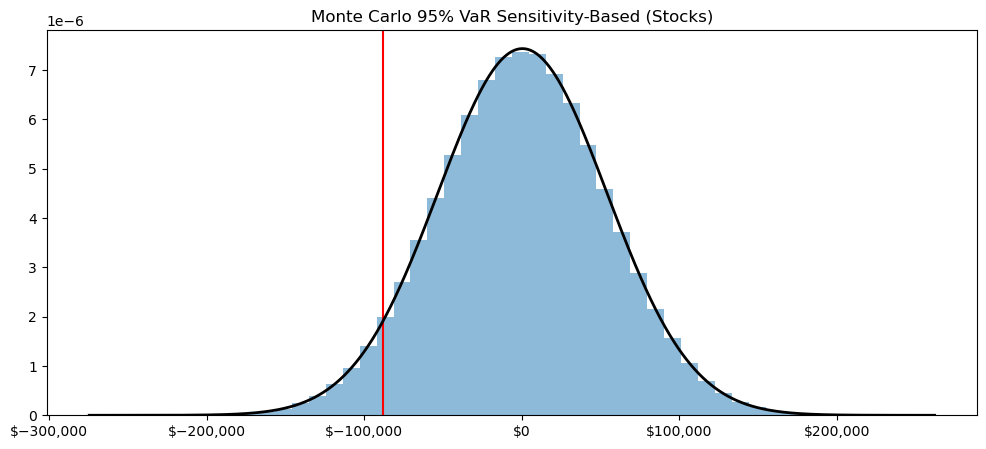

In [34]:
# multiply our return to notionals and sum all the simulated 4 stocks returns together daily (250 cols)
MC_SB_stocks_changes = (stock_simulated_returns * stocks_notional).sum(axis=1)

MC_SB_stocks_VaR = abs(np.percentile(MC_SB_stocks_changes, VaR_percentile))

print(f'Monte Carlo Sensitivity-Based Stocks 95% VaR: ${round(MC_SB_stocks_VaR, 2):,}')
plot_distribution(MC_SB_stocks_changes, MC_SB_stocks_VaR, 'Monte Carlo 95% VaR Sensitivity-Based (Stocks)')

### SWAP

Monte Carlo Sensitivity-Based SOFR Swap 95% VaR: $931,930.35


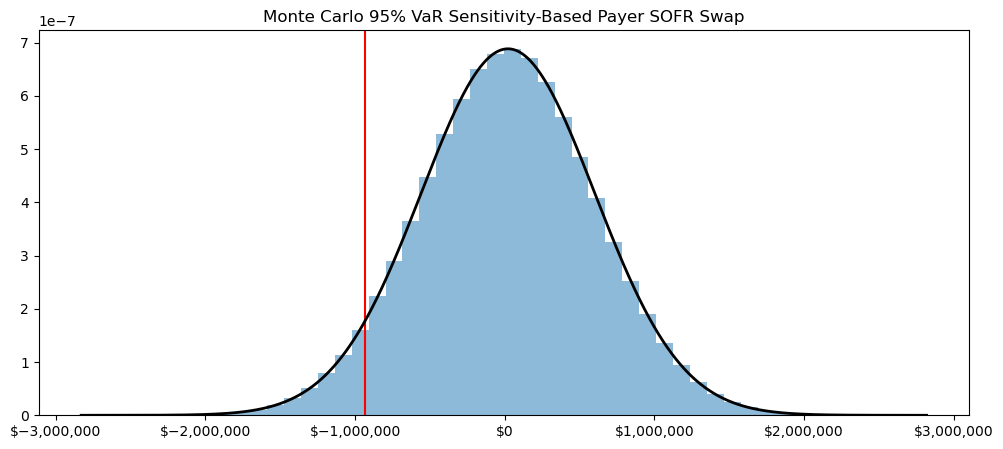

In [35]:
# compute payer swap value for each risk factor using PV01 and sum it along the row (daily like stocks)
MC_SB_payer = (pv01 * sofr_simulated).sum(axis = 1).astype(float)

MC_SB_payer_VaR = abs(np.percentile(MC_SB_payer, VaR_percentile))

print(f'Monte Carlo Sensitivity-Based SOFR Swap 95% VaR: ${round(MC_SB_payer_VaR, 2):,}')
plot_distribution(MC_SB_payer, MC_SB_payer_VaR, 'Monte Carlo 95% VaR Sensitivity-Based Payer SOFR Swap')

## Monte Carlo VaR - Sensitivity Based Approach Portfolio ($ P_0 $):

Monte Carlo Sensitivity Based Portfolio 95% VaR: $935,901.56


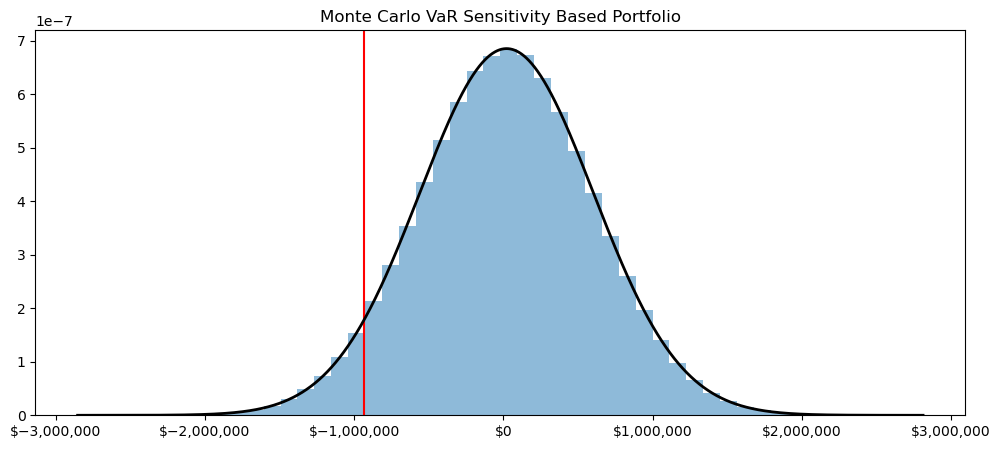

In [36]:
# combine together stock and swap
MC_SB_portfolio_changes = MC_SB_stocks_changes + MC_SB_payer

MC_SB_VaR = abs(np.percentile(MC_SB_portfolio_changes, VaR_percentile))

print(f"Monte Carlo Sensitivity Based Portfolio 95% VaR: ${MC_SB_VaR:,.2f}")
plot_distribution(MC_SB_portfolio_changes, MC_SB_VaR, 'Monte Carlo VaR Sensitivity Based Portfolio')


# (c) HISTORICAL VAR

## 1. Full Revaluation Approach

### STOCKS

Historical Full Revaluation Stock 95% VaR: $82,934.71


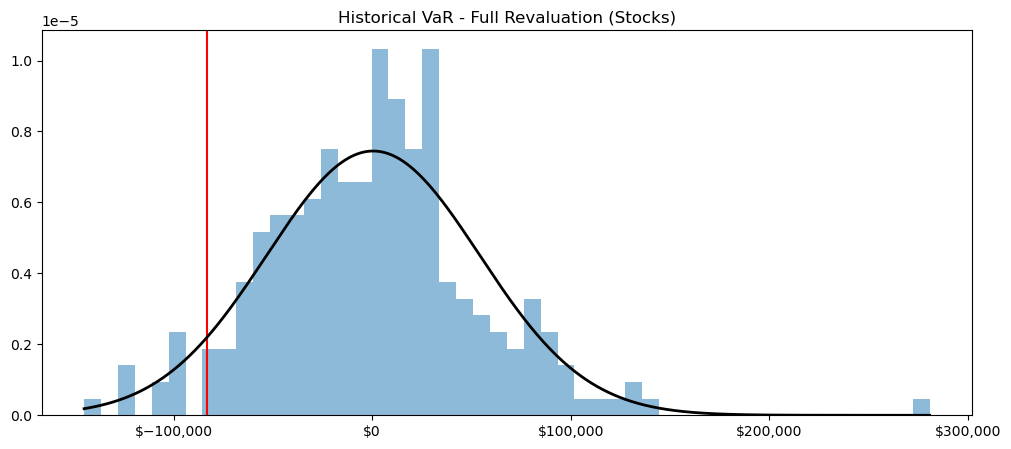

In [59]:
# apply latest stock price to the risk factor (stocks_daily_return) and get new stock prices
hist_FR_prices = latest_stock_price * (1 + stocks_daily_return) 

# multiply our shares and the new prices to get new portfolio
hist_FR_stocks_portfolio = share_holdings * hist_FR_prices   
hist_FR_stocks_portfolio_changes = (hist_FR_stocks_portfolio - stocks_notional).sum(axis = 1) 

hist_FR_stocks_VaR = abs(np.percentile(hist_FR_stocks_portfolio_changes, VaR_percentile))

print(f'Historical Full Revaluation Stock 95% VaR: ${round(hist_FR_stocks_VaR, 2):,}')
plot_distribution(hist_FR_stocks_portfolio_changes, hist_FR_stocks_VaR, 'Historical VaR - Full Revaluation (Stocks)')

### SWAP

Historical Full Revaluation Swap 95% VaR: $962,541.68


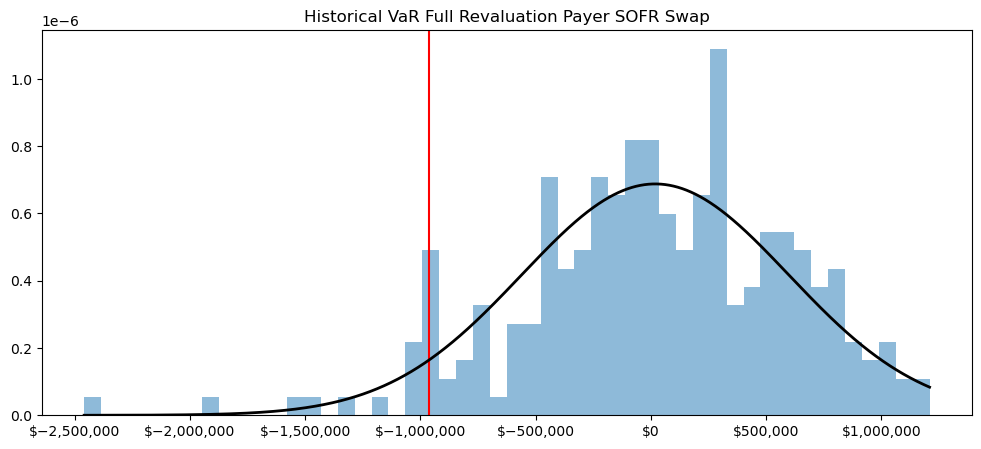

In [38]:
# apply historical rate changes to today's rates
new_sofr_10 = pd.DataFrame(latest_sofr_rate + sofr_delta.to_numpy())
# discount factors for each maturities
new_sofr_10_disc = compute_discount_factors(new_sofr_10).to_numpy() 

n = len(sofr_delta)
hist_FR_payer = np.zeros(n)

# compute payer swap value for each risk factor
for i in range(n):
    hist_FR_payer[i] = PV_payer_swap(new_sofr_10_disc[i])  

# calculate change in value of swap
hist_FR_payer = hist_FR_payer - base_pv    # base_pv: swap initial portfolio
hist_FR_payer_VaR = abs(np.percentile(hist_FR_payer, 5))

print(f'Historical Full Revaluation Swap 95% VaR: ${round(hist_FR_payer_VaR, 2):,}')
plot_distribution(hist_FR_payer, hist_FR_payer_VaR, 'Historical VaR Full Revaluation Payer SOFR Swap')


## Historical VaR - Full Revaluation Approach Portfolio ($ P_0 $):

Historical Full Revaluation Portfolio 95% VaR: $966,173.22


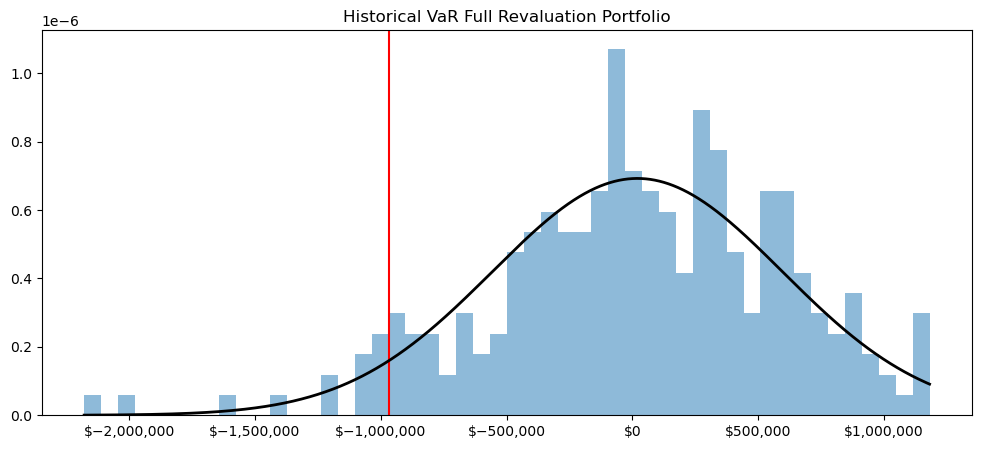

In [39]:
# combine together stock and swap
hist_FR_portfolio_changes = hist_FR_stocks_portfolio_changes + hist_FR_payer

hist_FR_VaR = abs(np.percentile(hist_FR_portfolio_changes, VaR_percentile))

print(f"Historical Full Revaluation Portfolio 95% VaR: ${hist_FR_VaR:,.2f}")
plot_distribution(hist_FR_portfolio_changes, hist_FR_VaR, 'Historical VaR Full Revaluation Portfolio')


## 2. Sensitivity-Based Approach



### STOCKS

Sensitivity-Based Stocks 95% VaR: $82,934.71


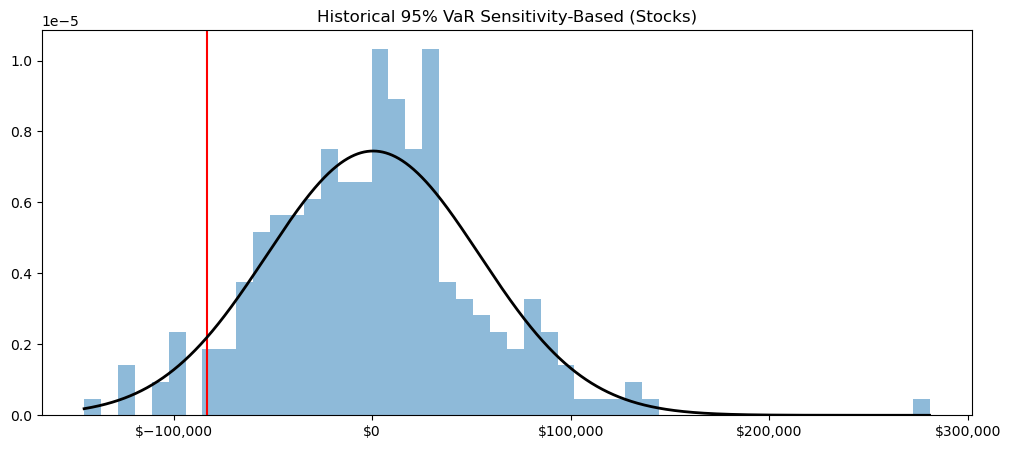

In [40]:
# multiply our return to notionals and sum all the 4 stocks together daily (250 cols)
hist_SB_stocks_changes = (stocks_daily_return * stocks_notional).sum(axis=1)

hist_SB_stocks_VaR = abs(np.percentile(hist_SB_stocks_changes, VaR_percentile))

print(f'Sensitivity-Based Stocks 95% VaR: ${round(hist_SB_stocks_VaR, 2):,}')
plot_distribution(hist_SB_stocks_changes, hist_SB_stocks_VaR, 'Historical 95% VaR Sensitivity-Based (Stocks)')


### SWAP

Sensitivity-Based SOFR Swap 95% VaR: $956,909.67


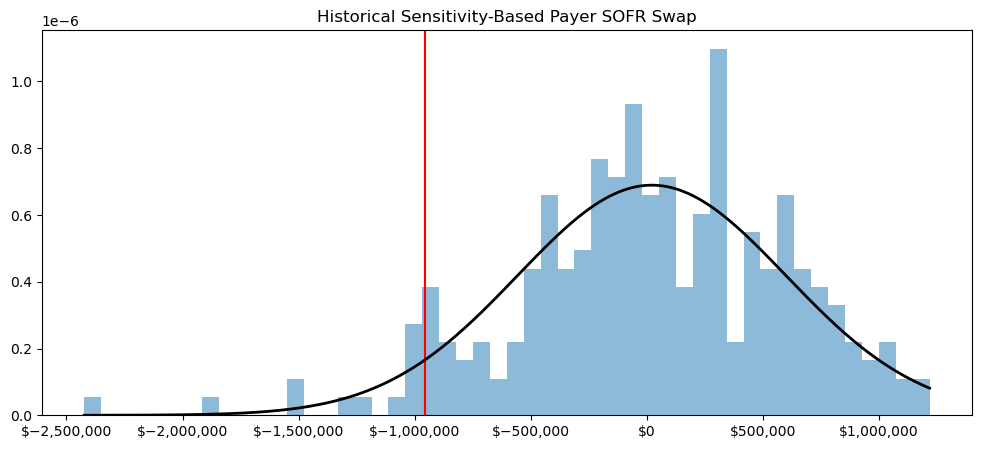

In [41]:
# compute payer swap value for each risk factor using PV01 and sum it along the row (daily like stocks)
hist_SB_payer = (pv01 * sofr_delta.to_numpy()).sum(axis = 1).astype(float)

hist_SB_payer_VaR = abs(np.percentile(hist_SB_payer, VaR_percentile))

print(f'Sensitivity-Based SOFR Swap 95% VaR: ${round(hist_SB_payer_VaR, 2):,}')
plot_distribution(hist_SB_payer, hist_SB_payer_VaR, 'Historical Sensitivity-Based Payer SOFR Swap')


## Historical VaR - Sensitivity Based Approach Portfolio ($ P_0 $):

Historical Sensitivity Based Portfolio 95% VaR: $960,687.72


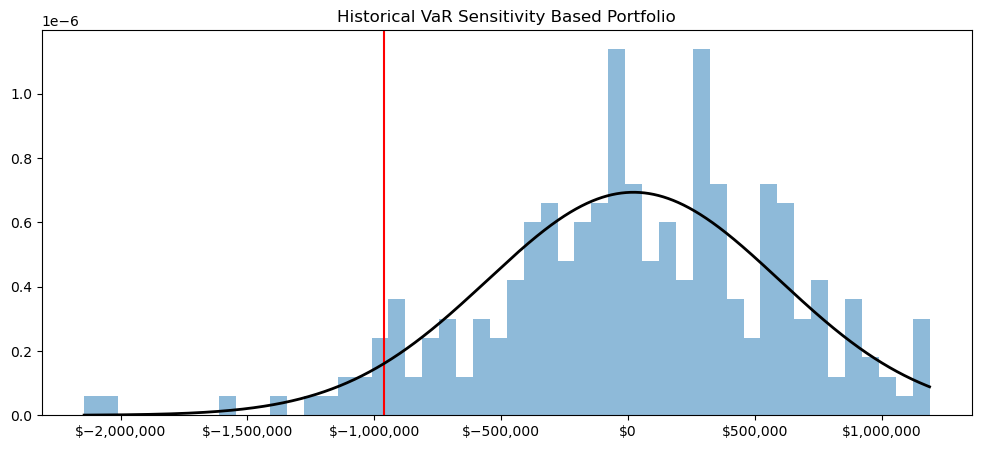

In [42]:
# combine together stock and swap
hist_SB_portfolio_changes = hist_SB_stocks_changes + hist_SB_payer

hist_SB_VaR = abs(np.percentile(hist_SB_portfolio_changes, VaR_percentile))

print(f"Historical Sensitivity Based Portfolio 95% VaR: ${hist_SB_VaR:,.2f}")
plot_distribution(hist_SB_portfolio_changes, hist_SB_VaR, 'Historical VaR Sensitivity Based Portfolio')
